<a href="https://colab.research.google.com/github/venkatesh-eranti/Media_company_case_study/blob/main/Media_company_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Statement:** A digital media company (similar to Voot, Hotstar, Netflix, etc.) had launched a show. Initially, the show got a good response, but then witnessed a decline in viewership. The company wants to figure out what went wrong

In [70]:
data='https://raw.githubusercontent.com/venkatesh-eranti/Media_company_case_study_multiple_linear_regression/main/mediacompany.csv'
data_dictionary='https://raw.githubusercontent.com/venkatesh-eranti/Media_company_case_study_multiple_linear_regression/main/DataDictionary_mediacompany.csv'

# Reading and understanding the data

## importing the necessary librariers

In [71]:
# reading and processing the data
import numpy as np
import pandas as pd
# visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
# supress the warnings
import warnings
warnings.filterwarnings('ignore')
# splitting the data in to train and test
from sklearn.model_selection import train_test_split
# rescaling the features
from sklearn.preprocessing import MinMaxScaler
# feature selection using RFE
from sklearn.feature_selection import RFE
# to use RFE we need to build model with sklearn
from sklearn.linear_model import LinearRegression
# statsmoldes to build linear regression
import statsmodels.api as sm
# to check multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
# evaluation metrics
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

## loading the data

In [72]:
df=pd.read_csv(data)
data_dictionary=pd.read_csv(data_dictionary)

In [73]:
df.head()

,Date,Views_show,Visitors,Views_platform,Ad_impression,Cricket_match_india,Character_A,Unnamed: 7
0,3/1/2017,183738,1260228,1706478,1060860448,0,0,NaN
1,3/2/2017,193763,1270561,1690727,1031846645,0,0,NaN
2,3/3/2017,210479,1248183,1726157,1010867575,0,0,NaN
3,3/4/2017,240061,1492913,1855353,1079194579,1,0,NaN
4,3/5/2017,446314,1594712,2041418,1357736987,0,0,NaN


In [74]:
data_dictionary

,Variable,Explaination
0,Views_show,Number of times the show was viewed
1,Visitors,"Number of visitors who browsed the platform, b..."
2,Views_platform,Number of times a video was viewed on the plat...
3,Ad_impression,Proxy for marketing budget. Represents number ...
4,Cricket_match_india,If a cricket match was being played. 1 indicat...
5,Character_A,Describes presence of Character A. 1 indicates...


to see the full text of a row with out truncation, we need to print it explicitly by using iloc or loc function

In [75]:
print(data_dictionary.iloc[0,0],'-->',data_dictionary.iloc[0,1])
print(data_dictionary.iloc[1,0],'-->',data_dictionary.iloc[1,1])
print(data_dictionary.iloc[2,0],'-->',data_dictionary.iloc[2,1])
print(data_dictionary.iloc[3,0],'-->',data_dictionary.iloc[3,1])
print(data_dictionary.iloc[4,0],'-->',data_dictionary.iloc[4,1])
print(data_dictionary.iloc[5,0],'-->',data_dictionary.iloc[5,1])

Views_show --> Number of times the show was viewed
Visitors --> Number of visitors who browsed the platform, but not necessarily watched a video. 
Views_platform --> Number of times a video was viewed on the platform 
Ad_impression --> Proxy for marketing budget. Represents number of impressions generated by ads
Cricket_match_india --> If a cricket match was being played. 1 indicates that there was a match on a given day, 0 indicates there wasn't
Character_A --> Describes presence of Character A. 1 indicates that character A was present in the episode, 0 indicates she/he wasn't


## understanding the data

In [76]:
df.shape

(80, 8)

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 80 non-null     object 
 1   Views_show           80 non-null     int64  
 2   Visitors             80 non-null     int64  
 3   Views_platform       80 non-null     int64  
 4   Ad_impression        80 non-null     int64  
 5   Cricket_match_india  80 non-null     int64  
 6   Character_A          80 non-null     int64  
 7   Unnamed: 7           0 non-null      float64
dtypes: float64(1), int64(6), object(1)
memory usage: 5.1+ KB


In [78]:
# dropping Unnamed: 7 column as it dont have any data
df.drop('Unnamed: 7',axis=1,inplace=True)

In [79]:
# converting data column to datetime format instead of object
df['Date']=pd.to_datetime(df['Date'])

In [80]:
df.head()

,Date,Views_show,Visitors,Views_platform,Ad_impression,Cricket_match_india,Character_A
0,2017-03-01,183738,1260228,1706478,1060860448,0,0
1,2017-03-02,193763,1270561,1690727,1031846645,0,0
2,2017-03-03,210479,1248183,1726157,1010867575,0,0
3,2017-03-04,240061,1492913,1855353,1079194579,1,0
4,2017-03-05,446314,1594712,2041418,1357736987,0,0


# Visualising the data

as per the problem statement **Visitors** are reducing for the show. <br> lets check that first

In [81]:
# checking the span of dates,if any dates are missing 
df['Date'].diff().value_counts()

1 days    79
Name: Date, dtype: int64

In [82]:
# getting day number from start of show
df['Day']=[day for day in range(1,len(df['Date'])+1)]

In [83]:
df.head(2)

,Date,Views_show,Visitors,Views_platform,Ad_impression,Cricket_match_india,Character_A,Day
0,2017-03-01,183738,1260228,1706478,1060860448,0,0,1
1,2017-03-02,193763,1270561,1690727,1031846645,0,0,2


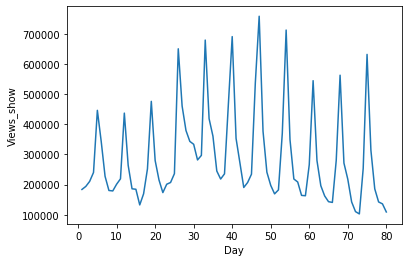

In [84]:
sns.lineplot(df['Day'],df['Views_show'])

## observations from line plot
1) as per the problem statement the peaks and as well as valleys of the line plot showed in decreasing trend <br>
2) visitors count spiking seems to have some pattern(may be on some weekends it is raising) <br> let's check it

In [85]:
df['Day_name']=df['Date'].dt.day_name()

In [86]:
df.groupby('Day_name')['Views_show'].sum().sort_values(ascending=False)

Day_name
Sunday       6591842
Monday       3709831
Saturday     3415315
Tuesday      2699435
Wednesday    2352461
Friday       2236404
Thursday     2186922
Name: Views_show, dtype: int64

as expected it is spiking on weekends.<br> so adding a column with 1 as weekends and 0 as normal days

In [87]:
df['Weekdend']=df['Day_name'].apply(lambda x: 1 if x=='Sunday' or x== 'Saturday' else 0)

In [88]:
df.head(5)

,Date,Views_show,Visitors,Views_platform,Ad_impression,Cricket_match_india,Character_A,Day,Day_name,Weekdend
0,2017-03-01,183738,1260228,1706478,1060860448,0,0,1,Wednesday,0
1,2017-03-02,193763,1270561,1690727,1031846645,0,0,2,Thursday,0
2,2017-03-03,210479,1248183,1726157,1010867575,0,0,3,Friday,0
3,2017-03-04,240061,1492913,1855353,1079194579,1,0,4,Saturday,1
4,2017-03-05,446314,1594712,2041418,1357736987,0,0,5,Sunday,1


## plotting pair plot to check the correlations

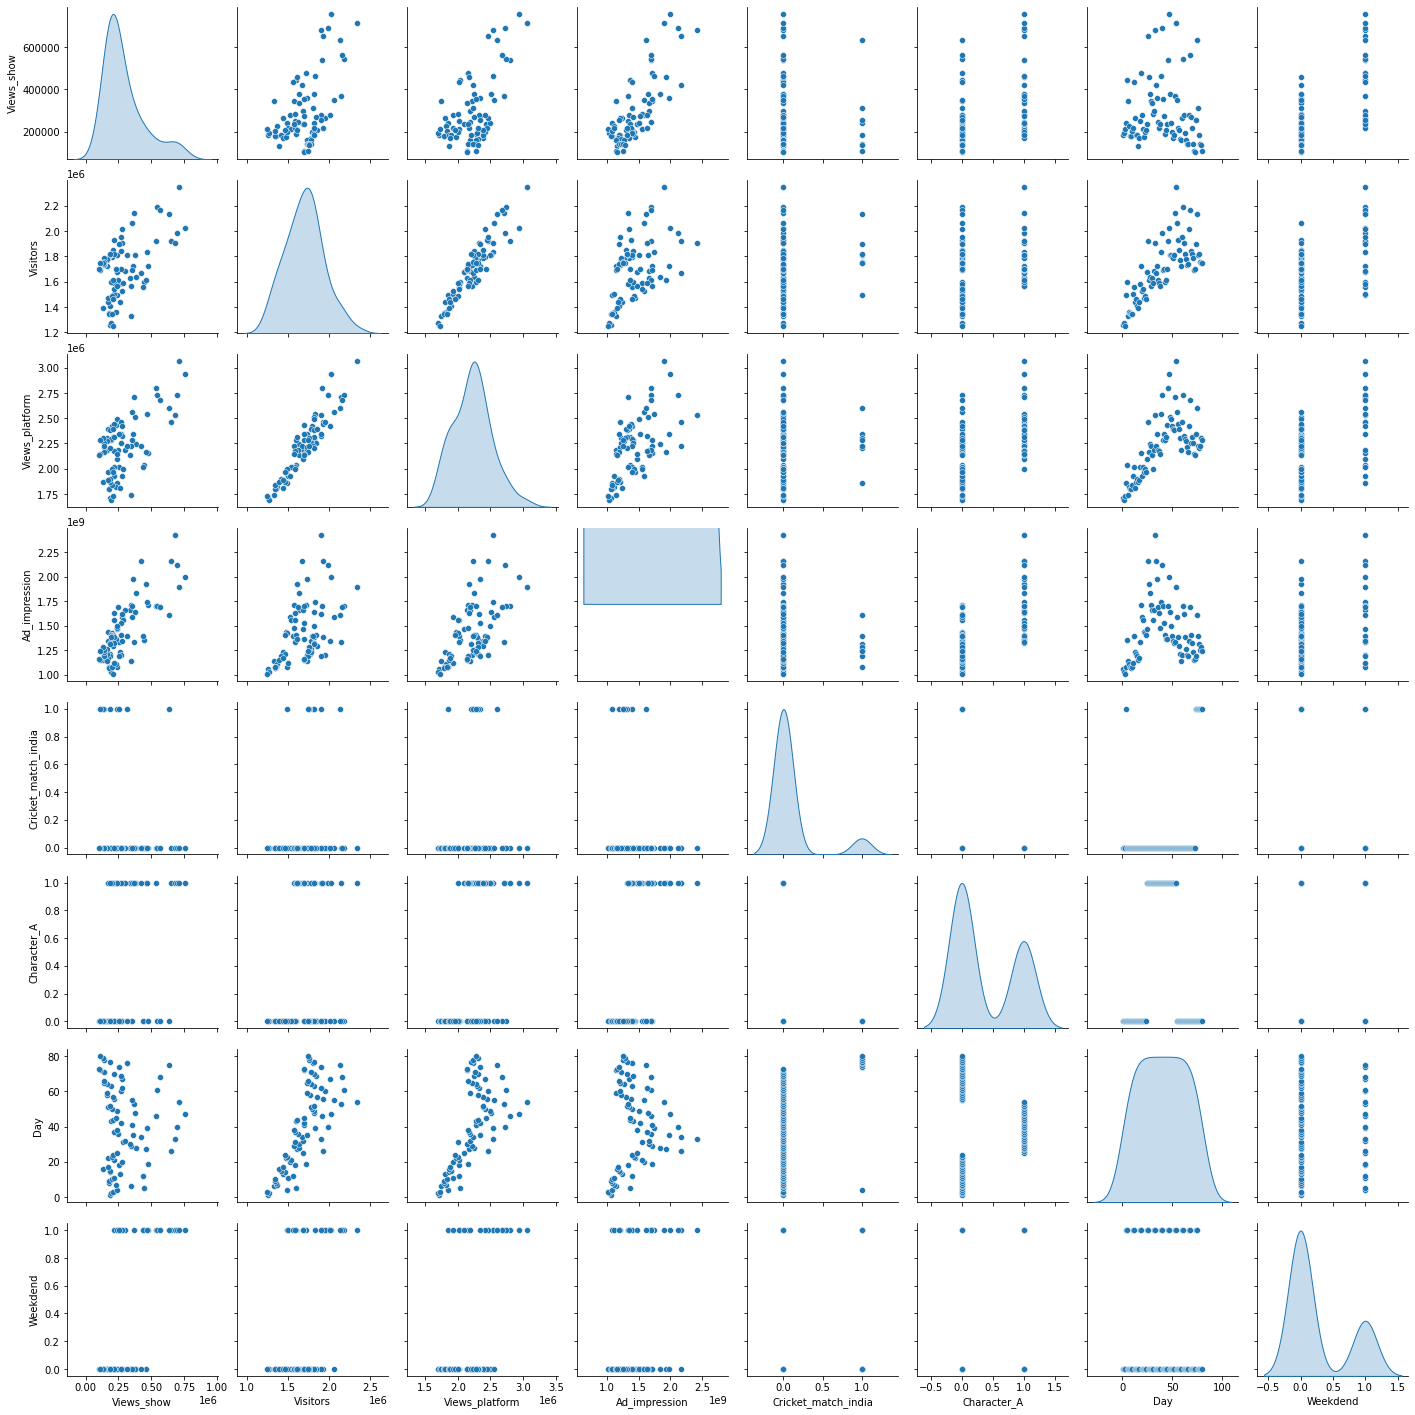

In [89]:
sns.pairplot(df,diag_kind='kde')

## plotting heatmap to check correaltion

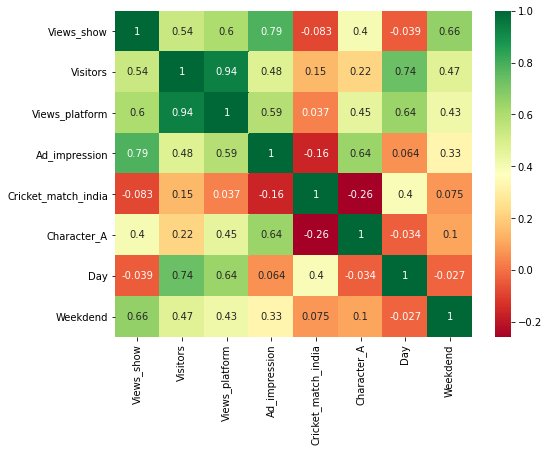

In [90]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn')

In [91]:
# making ad_impressions in millions
df['Ad_impression_million']=df['Ad_impression']/1000000

In [92]:
df.drop('Ad_impression',axis=1,inplace=True)

In [93]:
df.head(2)

,Date,Views_show,Visitors,Views_platform,Cricket_match_india,Character_A,Day,Day_name,Weekdend,Ad_impression_million
0,2017-03-01,183738,1260228,1706478,0,0,1,Wednesday,0,1060.860448
1,2017-03-02,193763,1270561,1690727,0,0,2,Thursday,0,1031.846645


# splitting training and testing data

considering Visitors,Views_paltform,Character_A, weekend and Ad_impressions from heatmap and pairplot

In [94]:
x=df.drop(['Date','Cricket_match_india','Day','Day_name','Views_show'],axis=1)
y=df['Views_show']

we dont have luxury of splitting the data in to train and test as we have less data

# building the model

## first linear model (lm1)

In [95]:
lm1=sm.OLS(y,sm.add_constant(x)).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Views_show   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     68.98
Date:                Sat, 14 Nov 2020   Prob (F-statistic):           1.87e-26
Time:                        07:05:50   Log-Likelihood:                -999.73
No. Observations:                  80   AIC:                             2011.
Df Residuals:                      74   BIC:                             2026.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -3.645e+05    7.2e+04     -5.064      0.000   -5.08e+05   -2.21e+05
Visitors                 -0.3269      0.124     -2.646      0.010      -0.573      -0.081
Views_platform            0.3062      0.105      2.923      0.005       0.097       0.515
Character_A           -7.556e+04    2.6e+04     -2.908      0.005   -1.27e+05   -2.38e+04
Weekdend                1.52e+05   1.94e+04      7.820      0.000    1.13e+05    1.91e+05
Ad_impression_million   357.7700     37.738      9.480      0.000     282.575     432.965
==============================================================================
Omnibus:                        5.595   Durbin-Watson:                   1.140
Prob(Omnibus):                  0.061   Jarque-Bera (JB):                4.939
Skew:                           0.588   Prob(JB):                       0.0846
Kurtosis:                       3.313   Cond. No.                     2.76e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.76e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### observations of lm1 model:
1) as, there is some difference between $R^2$ and $Adjusted-R^2$ there is still a room to reduce features <br> 2) P-value for visitors is more than 0.05. so need to remove this feature <br> 3) Charatcter_A showing negative coefficient with Views_show.(need further investigation on this)


##linear model (lm2)

In [96]:
x_Visitors=x.drop('Visitors',axis=1)

In [97]:
lm2=sm.OLS(y,sm.add_constant(x_Visitors)).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Views_show   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     78.21
Date:                Sat, 14 Nov 2020   Prob (F-statistic):           5.42e-26
Time:                        07:05:50   Log-Likelihood:                -1003.3
No. Observations:                  80   AIC:                             2017.
Df Residuals:                      75   BIC:                             2029.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -3.369e+05    7.4e+04     -4.552      0.000   -4.84e+05   -1.89e+05
Views_platform            0.0442      0.036      1.244      0.218      -0.027       0.115
Character_A           -3.468e+04   2.17e+04     -1.597      0.114   -7.79e+04    8575.698
Weekdend               1.429e+05   1.99e+04      7.187      0.000    1.03e+05    1.82e+05
Ad_impression_million   348.1848     39.038      8.919      0.000     270.417     425.953
==============================================================================
Omnibus:                        5.130   Durbin-Watson:                   1.142
Prob(Omnibus):                  0.077   Jarque-Bera (JB):                4.394
Skew:                           0.544   Prob(JB):                        0.111
Kurtosis:                       3.369   Cond. No.                     2.16e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.16e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### observations of lm2 model:
1) as, there is still some difference between $R^2$ and $Adjusted-R^2$ there is still a room to reduce features <br> 2) P-value for Views_platform is more than 0.05. so need to remove this feature <br> 3) Charatcter_A is still showing negative coefficient with Views_show.(need further investigation on this)


## Linear model (lm3)

In [98]:
x_Views_platform=x_Visitors.drop('Views_platform',axis=1)

In [99]:
lm3=sm.OLS(y,sm.add_constant(x_Views_platform)).fit()
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Views_show   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     103.0
Date:                Sat, 14 Nov 2020   Prob (F-statistic):           1.05e-26
Time:                        07:05:50   Log-Likelihood:                -1004.2
No. Observations:                  80   AIC:                             2016.
Df Residuals:                      76   BIC:                             2026.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -2.661e+05   4.74e+04     -5.609      0.000   -3.61e+05   -1.72e+05
Character_A            -2.99e+04   2.14e+04     -1.394      0.167   -7.26e+04    1.28e+04
Weekdend                1.51e+05   1.88e+04      8.019      0.000    1.14e+05    1.89e+05
Ad_impression_million   364.4670     36.909      9.875      0.000     290.957     437.977
==============================================================================
Omnibus:                        4.723   Durbin-Watson:                   1.169
Prob(Omnibus):                  0.094   Jarque-Bera (JB):                3.939
Skew:                           0.453   Prob(JB):                        0.139
Kurtosis:                       3.601   Cond. No.                     9.26e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### observations of lm3 model:
1) as, there is still some difference between $R^2$ and $Adjusted-R^2$ there is still a room to reduce features <br> 2) P-value for Character_A is more than 0.05 & still showing negative coefficient with Views_show so need to remove this feature


## Linear model lm4

In [100]:
x_Character_A=x_Views_platform.drop('Character_A',axis=1)

In [101]:
lm4=sm.OLS(y,sm.add_constant(x_Character_A)).fit()
lm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Views_show   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     151.7
Date:                Sat, 14 Nov 2020   Prob (F-statistic):           1.95e-27
Time:                        07:05:51   Log-Likelihood:                -1005.2
No. Observations:                  80   AIC:                             2016.
Df Residuals:                      77   BIC:                             2023.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -2.302e+05   4.01e+04     -5.744      0.000    -3.1e+05    -1.5e+05
Weekdend               1.551e+05   1.87e+04      8.282      0.000    1.18e+05    1.92e+05
Ad_impression_million   330.9993     28.203     11.736      0.000     274.840     387.159
==============================================================================
Omnibus:                        4.941   Durbin-Watson:                   1.282
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                4.423
Skew:                           0.399   Prob(JB):                        0.110
Kurtosis:                       3.831   Cond. No.                     7.52e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### observations of model lm4:
there is no big drop of $R^2$ after removing the `character_A`. <br>
but still i'm not convinced to drop `character-A` feature

### checking VIF for this lm4 model to check multicollineartiy

In [102]:
vif=pd.Series([variance_inflation_factor(x_Character_A.values,i) for i in range(x_Character_A.shape[1])],index=x_Character_A.columns)
vif

Weekdend                 1.481735
Ad_impression_million    1.481735
dtype: float64

### observations from VIF:
as both features are less than 5 from above VIF we can conclude that all features do not have any multicollinearity

# further investigation of character-A

plan is to divide dataset in to 2 parts. first one up to max views and another after decline <br> then we can decide character-A is pulling the viewer or not to the show

In [103]:
df[df['Views_show']==df['Views_show'].max()]

,Date,Views_show,Visitors,Views_platform,Cricket_match_india,Character_A,Day,Day_name,Weekdend,Ad_impression_million
46,2017-04-16,758631,2026102,2933930,0,1,47,Sunday,1,1992.525162


In [104]:
first_part=df[:47]
first_part.head()

,Date,Views_show,Visitors,Views_platform,Cricket_match_india,Character_A,Day,Day_name,Weekdend,Ad_impression_million
0,2017-03-01,183738,1260228,1706478,0,0,1,Wednesday,0,1060.860448
1,2017-03-02,193763,1270561,1690727,0,0,2,Thursday,0,1031.846645
2,2017-03-03,210479,1248183,1726157,0,0,3,Friday,0,1010.867575
3,2017-03-04,240061,1492913,1855353,1,0,4,Saturday,1,1079.194579
4,2017-03-05,446314,1594712,2041418,0,0,5,Sunday,1,1357.736987


## plotting a heatmap for first_part with character-A

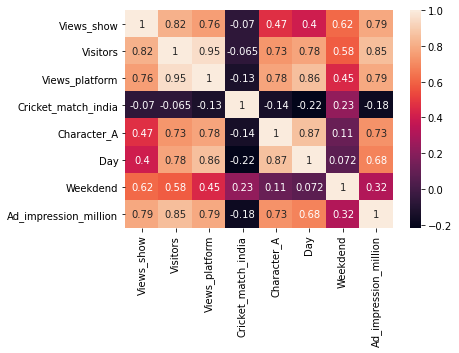

In [105]:
sns.heatmap(first_part.corr(),annot=True)

## building first linear model for first model with character-A

In [106]:
x_first_part=first_part.drop(['Views_show','Day_name','Date','Day'],axis=1)
y_first_part=first_part['Views_show']

In [107]:
sm.OLS(y_first_part,sm.add_constant(x_first_part)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Views_show   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     30.40
Date:                Sat, 14 Nov 2020   Prob (F-statistic):           1.99e-13
Time:                        07:05:51   Log-Likelihood:                -587.13
No. Observations:                  47   AIC:                             1188.
Df Residuals:                      40   BIC:                             1201.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -2.745e+05   2.04e+05     -1.348      0.185   -6.86e+05    1.37e+05
Visitors                 -0.4427      0.316     -1.402      0.169      -1.081       0.196
Views_platform            0.3725      0.146      2.555      0.015       0.078       0.667
Cricket_match_india   -1.332e+04   7.65e+04     -0.174      0.863   -1.68e+05    1.41e+05
Character_A           -8.523e+04   3.81e+04     -2.238      0.031   -1.62e+05   -8274.743
Weekdend               1.366e+05   4.05e+04      3.375      0.002    5.48e+04    2.18e+05
Ad_impression_million   334.5661     69.326      4.826      0.000     194.452     474.680
==============================================================================
Omnibus:                        0.729   Durbin-Watson:                   1.095
Prob(Omnibus):                  0.694   Jarque-Bera (JB):                0.748
Skew:                           0.274   Prob(JB):                        0.688
Kurtosis:                       2.716   Cond. No.                     5.40e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.4e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### observations of first part with character-A:
1) dropping Cricket_match_india as it is not statistically not significant

In [108]:
x_first_part_Cricket_match=x_first_part.drop('Cricket_match_india',axis=1)

## building linear model by dropping cricket match for first model

In [109]:
first_part_lm2=sm.OLS(y_first_part,sm.add_constant(x_first_part_Cricket_match)).fit()
first_part_lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Views_show   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     37.36
Date:                Sat, 14 Nov 2020   Prob (F-statistic):           3.11e-14
Time:                        07:05:51   Log-Likelihood:                -587.15
No. Observations:                  47   AIC:                             1186.
Df Residuals:                      41   BIC:                             1197.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -2.771e+05   2.01e+05     -1.381      0.175   -6.82e+05    1.28e+05
Visitors                 -0.4482      0.311     -1.443      0.157      -1.075       0.179
Views_platform            0.3766      0.142      2.648      0.011       0.089       0.664
Character_A            -8.59e+04   3.74e+04     -2.295      0.027   -1.62e+05   -1.03e+04
Weekdend               1.354e+05   3.94e+04      3.436      0.001    5.58e+04    2.15e+05
Ad_impression_million   336.5734     67.548      4.983      0.000     200.156     472.990
==============================================================================
Omnibus:                        0.816   Durbin-Watson:                   1.102
Prob(Omnibus):                  0.665   Jarque-Bera (JB):                0.823
Skew:                           0.290   Prob(JB):                        0.663
Kurtosis:                       2.712   Cond. No.                     5.39e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.39e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### observations from first_part_lm2 model
1) as, there is still some difference between $R^2$ and $Adjusted-R^2$ there is still a room to reduce features <br> 2) P-value for Visitors is more than 0.05 & still showing negative coefficient with Views_show so need to remove this feature

## building model by dropping Visitors

In [110]:
x_first_part_Visitors=x_first_part_Cricket_match.drop('Visitors',axis=1)

In [111]:
first_part_lm3=sm.OLS(y_first_part,sm.add_constant(x_first_part_Visitors)).fit()
first_part_lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Views_show   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     45.02
Date:                Sat, 14 Nov 2020   Prob (F-statistic):           1.17e-14
Time:                        07:05:51   Log-Likelihood:                -588.32
No. Observations:                  47   AIC:                             1187.
Df Residuals:                      42   BIC:                             1196.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -5.024e+05   1.28e+05     -3.934      0.000    -7.6e+05   -2.45e+05
Views_platform            0.2026      0.076      2.650      0.011       0.048       0.357
Character_A           -9.337e+04   3.76e+04     -2.486      0.017   -1.69e+05   -1.76e+04
Weekdend               9.442e+04   2.77e+04      3.413      0.001    3.86e+04     1.5e+05
Ad_impression_million   270.8625     50.539      5.359      0.000     168.870     372.855
==============================================================================
Omnibus:                        0.947   Durbin-Watson:                   1.000
Prob(Omnibus):                  0.623   Jarque-Bera (JB):                0.906
Skew:                           0.315   Prob(JB):                        0.636
Kurtosis:                       2.744   Cond. No.                     2.75e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.75e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### checking for multicollinearity by using VIF for first_part_lm3

In [112]:
vif_first_part_lm3=pd.Series([variance_inflation_factor(x_first_part_Visitors.values,i)for i in range(x_first_part_Visitors.shape[1])],
                             index=x_first_part_Visitors.columns)
vif_first_part_lm3

Views_platform           50.973480
Character_A               2.944796
Weekdend                  1.545847
Ad_impression_million    57.736095
dtype: float64

### dropping Ad_impression_million from the above model and rerun the model

In [113]:
x_first_part_Ad_impression_million=x_first_part_Visitors.drop('Ad_impression_million',axis=1)
first_part_lm4=sm.OLS(y_first_part,sm.add_constant(x_first_part_Ad_impression_million)).fit()
first_part_lm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Views_show   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     30.67
Date:                Sat, 14 Nov 2020   Prob (F-statistic):           9.20e-11
Time:                        07:05:51   Log-Likelihood:                -600.56
No. Observations:                  47   AIC:                             1209.
Df Residuals:                      43   BIC:                             1217.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -4.941e+05   1.64e+05     -3.017      0.004   -8.24e+05   -1.64e+05
Views_platform     0.3759      0.089      4.231      0.000       0.197       0.555
Character_A    -3.629e+04   4.62e+04     -0.786      0.436   -1.29e+05    5.68e+04
Weekdend        1.037e+05   3.54e+04      2.930      0.005    3.23e+04    1.75e+05
==============================================================================
Omnibus:                        2.110   Durbin-Watson:                   1.319
Prob(Omnibus):                  0.348   Jarque-Bera (JB):                1.485
Skew:                           0.210   Prob(JB):                        0.476
Kurtosis:                       2.237   Cond. No.                     2.75e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.75e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### it is clear that Character_A is not significant to increase the visitors. so , we can consider our earlier lm4 was better model

In [114]:
lm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Views_show   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     151.7
Date:                Sat, 14 Nov 2020   Prob (F-statistic):           1.95e-27
Time:                        07:05:51   Log-Likelihood:                -1005.2
No. Observations:                  80   AIC:                             2016.
Df Residuals:                      77   BIC:                             2023.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -2.302e+05   4.01e+04     -5.744      0.000    -3.1e+05    -1.5e+05
Weekdend               1.551e+05   1.87e+04      8.282      0.000    1.18e+05    1.92e+05
Ad_impression_million   330.9993     28.203     11.736      0.000     274.840     387.159
==============================================================================
Omnibus:                        4.941   Durbin-Watson:                   1.282
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                4.423
Skew:                           0.399   Prob(JB):                        0.110
Kurtosis:                       3.831   Cond. No.                     7.52e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# making predictions using lm4 model

In [115]:
y_pred=lm4.predict(sm.add_constant(x_Character_A))

# evaluating the model

In [116]:
r2_score(y,y_pred)

0.7975978797926214

In [117]:
mean_absolute_error(y,y_pred)

53281.597012922444

In [118]:
mean_squared_error(y,y_pred)

4797239258.824437

Text(0, 0.5, 'Views')

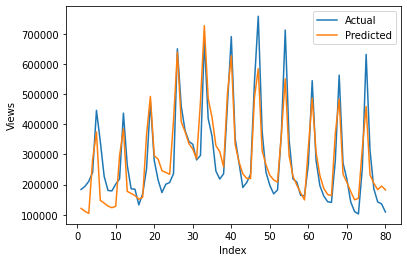

In [119]:
sns.lineplot(df['Day'],y,label='Actual')
sns.lineplot(df['Day'],y_pred,label='Predicted')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Views')

## Error terms

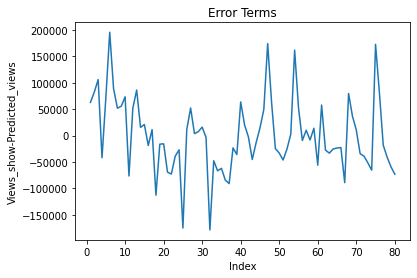

In [120]:
sns.lineplot(df['Day'],y-y_pred)
plt.xlabel('Index')
plt.ylabel('Views_show-Predicted_views')
plt.title('Error Terms')
plt.show()

# interpretation:
as per our analysis `Weekend` and `Ad_impressions` are key features. <br> as, we can not control the weekend we need to increase `Ad_impressions` to get more visitors to the show. <br>. the equation for best fit line is: <br>
$ Views-show =  -2.302^5 + (1.551^5 \times weekend) + (331 \times Ad-impression-millin) $

* for every unit increse in `weekend` the visitors_show will increase by $1.551^5$ (by holding all other varialbles constant)
* for every unit increase in `Ad_impression_million` the visitors_show will increase by 331 (by holding all other varialbles constant)

# answer to marketing team


In [121]:
df.head()

,Date,Views_show,Visitors,Views_platform,Cricket_match_india,Character_A,Day,Day_name,Weekdend,Ad_impression_million
0,2017-03-01,183738,1260228,1706478,0,0,1,Wednesday,0,1060.860448
1,2017-03-02,193763,1270561,1690727,0,0,2,Thursday,0,1031.846645
2,2017-03-03,210479,1248183,1726157,0,0,3,Friday,0,1010.867575
3,2017-03-04,240061,1492913,1855353,1,0,4,Saturday,1,1079.194579
4,2017-03-05,446314,1594712,2041418,0,0,5,Sunday,1,1357.736987


In [126]:
df['week']=df['Date'].dt.week

## getting data for Ad_impressions and Views shows as per week

In [135]:
df1=pd.DataFrame()
df1['Ad_impression_million_weekly_groth']=df.groupby('week')['Ad_impression_million'].sum().pct_change()*100
df1['Views_show_weekly']=df.groupby('week')['Views_show'].sum()

In [136]:
df1.head(10)

,Ad_impression_million_weekly_groth,Views_show_weekly
week,,
9,NaN,1274355
10,44.335303,1786676
11,12.545282,1663495
12,22.588707,1962729
13,15.737253,2774724
14,0.214422,2634495
15,-13.664787,2552385
16,-5.623470,2248940
17,-8.607005,1913677


and we can observe at week 13 the views are at peak and as the week is passing by the Ad_impressions are also reducing.<br> so to get more views the marketing budget needs to be improved on Ad_impressions